# Project Exploration
## The Dataset and What we hope to do with it:
- The dataset we are using is the concatenated data of the 2015 Human Development Report, taken from Kaggle and developed by the United Nations.
- This data includes the average, standard deviation, min, and max of all variables that are a float, which is nice for describing it.
- It uses 45 variables that are supposed to describe the development of each of 195 listed countries. 
- A weird and potentially troublesome thing about this is it doesn't include all countries and has some 'countries' that are not always considered countries by definition. We will thus be taking out the 'countries' that are not recognized by the formal United Nations.
- Another issue is that there is a limitation of validity because the numbers are self reported and in some categories absent. We plan to take out some countries for their absence of data (taking out any with more than 10 missing values) and take our results with a grain of salt.

Our problem/goal: We hope to be able to use our model to find the GDI (Gender Development Index) from the HDI (Human Development Index) within the MDI (Multidimensional Poverty Index) of any country with our dataset. 
- We are going to keep the whole concatonated dataset and the MPI dataset seperate because they refer to different countries and we want to make multiple regression models that fit the NaN values between them before combining the dataset.

## Descriptive plots and graphs:

In [379]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from pandas import read_csv
import sklearn
import numpy as np
from pprint import pprint
import math 
import locale
from locale import atof
import numpy.random as rn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor


locale.setlocale(locale.LC_NUMERIC, '')

gd_data = read_csv("https://www.dropbox.com/s/upot2a908xz26mn/gender_development.csv?dl=1")
gi_data = read_csv("https://www.dropbox.com/s/ensgp6e3chobe5x/gender_inequality.csv?dl=1")
hi_data = read_csv("https://www.dropbox.com/s/3u7udv2hlseddcb/historical_index.csv?dl=1")
ia_data = read_csv("https://www.dropbox.com/s/t7z4t0dj0ik16vc/inequality_adjusted.csv?dl=1")
hd_data = read_csv("https://www.dropbox.com/s/pjijqqsebk9vuwl/human_development.csv?dl=1")
mpi_data = read_csv('https://www.dropbox.com/s/jq78geqaa7qaobs/multidimensional_poverty.csv?dl=1')

In [380]:
whole_data = pd.concat([gd_data, gi_data,hd_data,ia_data,hi_data],axis=1,sort=False, copy = True).drop(['HDI Rank',
       'Human Development Index (HDI)'], axis =1)

In [381]:
whole_data = whole_data.loc[:,~whole_data.columns.duplicated()]

In [382]:
for column in whole_data.columns:
    for row in whole_data.index: 
        if whole_data.loc[row,column] == '..':
            whole_data.loc[row,column]= np.nan
for column in mpi_data.columns:
    for row in mpi_data.index: 
        if mpi_data.loc[row,column] == '..':
            mpi_data.loc[row,column]= np.nan

In [383]:
whole_data.drop(whole_data.index[188:194], axis =0)
whole_data =whole_data.drop(['Income Inequality (Quintile Ratio)','Income Inequality (Palma Rati)', 'Income Inequality (Gini Coefficient)'], axis =1)

In [384]:
mpi_data.head()

,Country,Year and Survey,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,2010/2011 M,0.293,58.8,0.353,66.2,"17,116",49.9,45.6,19.2,35.2,35.8,NaN
1,Albania,2008/2009 D,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Argentina,2005 N,0.015,3.7,0.011,2.9,"1,438",39.1,38.2,27.8,34.0,NaN,1.4
3,Armenia,2010 D,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32.0,1.8
4,Azerbaijan,2006 D,0.009,2.4,0.021,5.3,210,38.2,20.0,50.7,29.3,5.3,0.3


In [385]:
for col in whole_data.columns:
    if col != 'Country':
        for i in range(len(whole_data[col])):
            if type(whole_data[col][i]) not in [np.float64, float] and whole_data[col][i] is not None:
                whole_data[col][i] = np.float64(whole_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [386]:
for col in mpi_data.columns:
    if col != 'Country' and col != 'Year and Survey':
        for i in range(len(mpi_data[col])):
            if type(mpi_data[col][i]) not in [np.float64, float] and mpi_data[col][i] is not None:
                mpi_data[col][i] = np.float64(mpi_data[col][i].replace(",","_"))

C:\tools\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Regression Models for Filling Gaps
## Now we need to create regression models to fill in non-existant data points. To do this we must first drop points that have little to no data. 
- We use the loc feature to find all NaN  points. If there are >10 we will delete th erow to protect the integrity of the model. The following must be removed from the data set

- 'Hong Kong, China (SAR)'
- 'Liechtenstein'
- 'Brunei Darussalam' 
- 'Andorra' 
- 'Bahamas'
- 'Antigua and Barbuda'
- 'Palau'
- 'Seychelles' 
- 'Saint Kitts and Nevis'
- 'Grenada'
- 'Bosnia and Herzegovina'
- 'Dominica'
- 'Saint Vincent and the Grenadines'
- 'Turkmenistan'
- 'Gabon'
- 'Viet Nam'
- 'Cabo Verde'
- 'Micronesia (Federated States of)'
- 'Kiribati'
- 'Equatorial Guinea'
- 'Myanmar'
- 'Angola'
- 'Solomon Islands'
- 'Papua New Guinea'
- 'Haiti'
- 'Djibouti'
- 'Guinea-Bissau'
- 'Eritrea'

In [387]:
whole_data = whole_data.drop([whole_data.index[11], whole_data.index[12], whole_data.index[30], whole_data.index[33],
                 whole_data.index[54], whole_data.index[57] ,whole_data.index[59], whole_data.index[63], whole_data.index[76],
                 whole_data.index[78], whole_data.index[86], whole_data.index[93], whole_data.index[97],
                 whole_data.index[108], whole_data.index[109], whole_data.index[117], whole_data.index[121],
                 whole_data.index[122], whole_data.index[137], whole_data.index[136], whole_data.index[147],
                 whole_data.index[148], whole_data.index[156], whole_data.index[157], whole_data.index[162],
                 whole_data.index[167], whole_data.index[177], whole_data.index[185]], axis =0)
## Drop Year and survey 
mpi_data = mpi_data.drop(mpi_data.columns[1], axis =1)

In [388]:
for column in whole_data.columns:
    df = whole_data[pd.notna(whole_data.loc[:,column])]
    df = df.dropna()

## whole_data
#### Now we need to find regression models (and test using bootstrapping and cross validation) for:
- Inequality in Education                                 
- Inequality-Adjusted Education Index                        
- Inequality in Income                                       
- Inequality-Adjusted Income Index 
- Inequality-adjusted HDI (IHDI)         
- IHDI Loss Percent                                         
- IHDI Rank Difference                                      
- Coefficient of Human Inequality                           
- Inequality in Life Expectancy  

##### We will create a vanilla regression, a  ridge regression, and lasso regression models for each to determine the missing values
______________________________________________________________________
# Functions

In [389]:
def createTestTrain(data,labelX,labely):
    X = np.atleast_2d(np.array([float(h) for h in data.loc[:, labelX].dropna()])).transpose()
    y = np.array(data.loc[:,labely])
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)
    X = X[perm]
    y = y[perm]
    X_test = X[:test]      
    y_test = y[:test]
    X_train = X[test:]     
    y_train = y[test:]
    return X_test, y_test, X_train, y_train, X, y

In [390]:
def crossVal(X,y):  
    n = X.shape[0]
    test = int(0.20*n)           
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    R2 = pd.DataFrame( np.array([ [0]*5, [0]*5, [0]*5, [0]*5]).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])
    

    for k in range(5):
        X_test = X[k*test:(k+1)*test]      
        y_test = y[k*test:(k+1)*test]
        X_train = np.concatenate( (X[:k*test], X[(k+1)*test:]), axis=0)     
        y_train = np.concatenate( (y[:k*test], y[(k+1)*test:]), axis=0)
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = [0, 1, 2, 3, 4, 'Mean', 'Standard Deviation']
    return R2

In [391]:
def boots(X,y):
    num = 40 
    Xboot = [0]*num
    yboot = [0]*num

    n = X.shape[0]
    for k in range(num):
        sample = np.random.randint(0, n, n) 
        Xboot[k] = X[sample, :]
        yboot[k] = y[sample]
    test = int(0.20*n)
    R2 = pd.DataFrame( np.array([ [0]*num]*4).transpose(), columns = ['train_1', 'test_1', 'train_2', 'test_2'])

    for k in range(num):
        X_test = Xboot[k][:test]
        y_test = yboot[k][:test]
        X_train = Xboot[k][test:]
        y_train = yboot[k][test:]
        reg = LinearRegression().fit(X_train, y_train)
        reg2 = LinearRegression().fit(X_train[:, 0:6], y_train)

        R2.loc[k, 'train_1'] = reg.score(X_train, y_train)
        R2.loc[k, 'test_1'] = reg.score(X_test, y_test)
        R2.loc[k, 'train_2'] = reg2.score(X_train[:, 0:6], y_train)
        R2.loc[k, 'test_2'] = reg2.score(X_test[:, 0:6], y_test)

    R2mean = [0]*4
    R2std = [0]*4
    for c in range(4):
        R2mean[c] = np.mean(R2.iloc[0:5, c])
        R2std[c] = np.std(R2.iloc[0:5, c])

    R2 = R2.append( pd.Series(R2mean, index=R2.columns), ignore_index=True )
    R2 = R2.append( pd.Series(R2std, index=R2.columns), ignore_index=True)
    R2.index = list(range(num)) + ['Mean', 'Standard Deviation']
    return R2.tail(10)

In [392]:
def plotfig():
    plt.plot(X_train, y_train, 'b.')
    plt.plot(X_test, y_test, 'g*')
    xx = np.linspace(0, 1.2, 20)
    yy = b + m*xx
    plt.plot(xx, yy, 'm-')

In [393]:
def filldata(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,44]
            data.iloc[row,index] = m*x+b

In [394]:
def filldatampi(data, m, b, index):
    ineq = data.columns[index]
    for row in range(len(ineq)):
        if np.isnan(data.iloc[row,index]):
            x = data.iloc[row,2]
            data.iloc[row,index] = m*x+b

In [395]:
def plot_reg_model(reg, X, y):

    # We shuffle the data using a random permutation

    n = X.shape[0]
    test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]       # Then create the test
    y_test = y[:test]
    X_train = X[test:]     # and train sets
    y_train = y[test:]
    
    reg.fit(X_train, y_train) # Fit the model
     
    nn = 200
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min()-0.1, X[:, 0].max()+0.1
    y_min, y_max = X[:, 1].min()-0.1, X[:, 1].max()+0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),   # Changed the function to use linspace rather than arrange
        np.linspace(y_min, y_max, nn))                    # This keeps us from having to adjust h.
    Z = reg.predict(np.c_[xx.ravel(), yy.ravel()]) # predict

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contour(xx, yy, Z)
    
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='+');
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))
    
    return reg

### Inequality in Education:

In [396]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Education")

72.29106389401713 -75.32101847299023


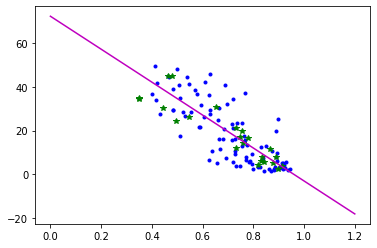

In [397]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [398]:
filldata(whole_data,m,b,34)

In [399]:
crossVal(X,y) 

,train_1,test_1,train_2,test_2
0,0.687049,0.449536,0.687049,0.449536
1,0.643989,0.687085,0.643989,0.687085
2,0.644131,0.685899,0.644131,0.685899
3,0.630715,0.720709,0.630715,0.720709
4,0.668392,0.555910,0.668392,0.555910
Mean,0.654855,0.619828,0.654855,0.619828
Standard Deviation,0.020177,0.102128,0.020177,0.102128


In [400]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.663330,0.744144,0.663330,0.744144
33,0.630121,0.576213,0.630121,0.576213
34,0.568001,0.724380,0.568001,0.724380
35,0.694207,0.756378,0.694207,0.756378
36,0.614817,0.565786,0.614817,0.565786
37,0.711616,0.755209,0.711616,0.755209
38,0.664361,0.596847,0.664361,0.596847
39,0.553238,0.600591,0.553238,0.600591
Mean,0.639008,0.655365,0.639008,0.655365
Standard Deviation,0.051551,0.080478,0.051551,0.080478


### Inequality-Adjusted Education Index:

In [401]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Education Index")

-0.3899827407265437 1.3178152828116856


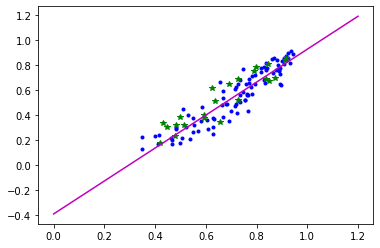

In [402]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [403]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8627098303590618
The testing R2: 0.8107915336789739


In [404]:
filldata(whole_data,m,b,35)

In [405]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.848548,0.854149,0.848548,0.854149
1,0.859257,0.836259,0.859257,0.836259
2,0.844419,0.863152,0.844419,0.863152
3,0.859410,0.831551,0.859410,0.831551
4,0.869003,0.760245,0.869003,0.760245
Mean,0.856127,0.829071,0.856127,0.829071
Standard Deviation,0.008728,0.036291,0.008728,0.036291


In [406]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.879279,0.877320,0.879279,0.877320
33,0.880838,0.815053,0.880838,0.815053
34,0.863137,0.861934,0.863137,0.861934
35,0.830416,0.856179,0.830416,0.856179
36,0.890055,0.840943,0.890055,0.840943
37,0.861974,0.932727,0.861974,0.932727
38,0.849035,0.850941,0.849035,0.850941
39,0.843251,0.893196,0.843251,0.893196
Mean,0.867947,0.812563,0.867947,0.812563
Standard Deviation,0.012425,0.081789,0.012425,0.081789


### Inequality-Adjusted Income Index:

In [407]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Human Development Index (2014)","Inequality-Adjusted Income Index")

-0.15695446571143412 0.9783236354601684


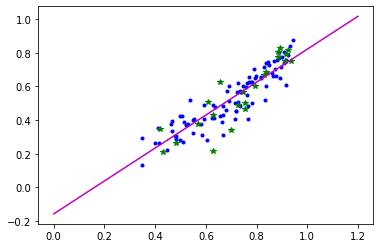

In [408]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [409]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8265981007347789
The testing R2: 0.7844351235026041


In [410]:
filldata(whole_data,m,b,37)

In [411]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.827561,0.782201,0.827561,0.782201
1,0.798199,0.869137,0.798199,0.869137
2,0.823166,0.784600,0.823166,0.784600
3,0.810719,0.846516,0.810719,0.846516
4,0.822767,0.747744,0.822767,0.747744
Mean,0.816483,0.806040,0.816483,0.806040
Standard Deviation,0.010718,0.044824,0.010718,0.044824


In [412]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.781552,0.755337,0.781552,0.755337
33,0.800509,0.865530,0.800509,0.865530
34,0.845168,0.793090,0.845168,0.793090
35,0.803446,0.860007,0.803446,0.860007
36,0.820848,0.790542,0.820848,0.790542
37,0.843913,0.690447,0.843913,0.690447
38,0.749985,0.766654,0.749985,0.766654
39,0.830695,0.947235,0.830695,0.947235
Mean,0.810425,0.827726,0.810425,0.827726
Standard Deviation,0.025719,0.059099,0.025719,0.059099


### Inequality-adjusted HDI (IHDI):

In [413]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality-adjusted HDI (IHDI)")

-0.27099932677900473 1.2021983279295418


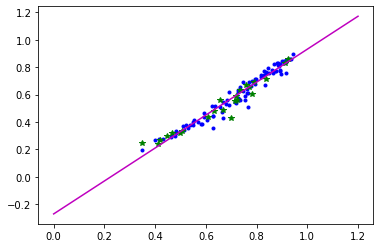

In [414]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [415]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.9570542078820783
The testing R2: 0.9383073795571631


In [416]:
filldata(whole_data,m,b,28)

In [417]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.956675,0.949588,0.956675,0.949588
1,0.958386,0.940942,0.958386,0.940942
2,0.952867,0.967263,0.952867,0.967263
3,0.954862,0.956568,0.954862,0.956568
4,0.955126,0.955750,0.955126,0.955750
Mean,0.955583,0.954022,0.955583,0.954022
Standard Deviation,0.001852,0.008667,0.001852,0.008667


In [418]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.956828,0.962409,0.956828,0.962409
33,0.958294,0.976552,0.958294,0.976552
34,0.970534,0.959644,0.970534,0.959644
35,0.954100,0.970516,0.954100,0.970516
36,0.938074,0.969792,0.938074,0.969792
37,0.948003,0.971330,0.948003,0.971330
38,0.938107,0.964029,0.938107,0.964029
39,0.958871,0.914902,0.958871,0.914902
Mean,0.954151,0.947939,0.954151,0.947939
Standard Deviation,0.010408,0.010418,0.010408,0.010418


### IHDI Loss Percent:

In [419]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","IHDI Loss Percent")

61.57942438016965 -58.08169968677541


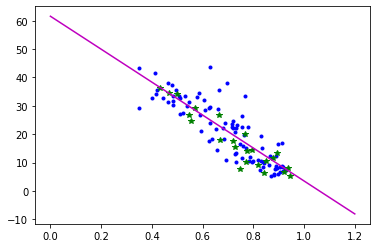

In [420]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [421]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.7358156285814925
The testing R2: 0.835835663513588


In [422]:
filldata(whole_data,m,b,29)

In [423]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.760771,0.713242,0.760771,0.713242
1,0.769068,0.659709,0.769068,0.659709
2,0.747619,0.788132,0.747619,0.788132
3,0.764684,0.722174,0.764684,0.722174
4,0.754543,0.764302,0.754543,0.764302
Mean,0.759337,0.729512,0.759337,0.729512
Standard Deviation,0.007558,0.044357,0.007558,0.044357


In [424]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.778982,0.765251,0.778982,0.765251
33,0.695778,0.708793,0.695778,0.708793
34,0.754060,0.874273,0.754060,0.874273
35,0.748478,0.810628,0.748478,0.810628
36,0.797243,0.802720,0.797243,0.802720
37,0.798874,0.672002,0.798874,0.672002
38,0.831146,0.832143,0.831146,0.832143
39,0.695312,0.579271,0.695312,0.579271
Mean,0.726290,0.772201,0.726290,0.772201
Standard Deviation,0.036007,0.102377,0.036007,0.102377


### Coefficient of Human Inequality:

In [425]:
X_test, y_test, X_train, y_train,X, y = createTestTrain(df,"Human Development Index (2014)","Coefficient of Human Inequality")

60.77622087447841 -58.37671405254002


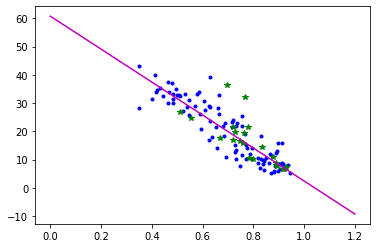

In [426]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [427]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.79953896325461
The testing R2: 0.5598272802762609


In [428]:
filldata(whole_data,m,b,31)

In [429]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.780224,0.699125,0.780224,0.699125
1,0.793373,0.669840,0.793373,0.669840
2,0.783239,0.738466,0.783239,0.738466
3,0.769120,0.797392,0.769120,0.797392
4,0.764108,0.788891,0.764108,0.788891
Mean,0.778013,0.738743,0.778013,0.738743
Standard Deviation,0.010398,0.049541,0.010398,0.049541


In [430]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.761767,0.726547,0.761767,0.726547
33,0.796912,0.723556,0.796912,0.723556
34,0.721929,0.934815,0.721929,0.934815
35,0.790398,0.813139,0.790398,0.813139
36,0.842342,0.789414,0.842342,0.789414
37,0.781254,0.727509,0.781254,0.727509
38,0.692572,0.758509,0.692572,0.758509
39,0.788944,0.817695,0.788944,0.817695
Mean,0.784994,0.775641,0.784994,0.775641
Standard Deviation,0.029295,0.028941,0.029295,0.028941


### Inequality in Life Expectancy: 

In [431]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Human Development Index (2014)","Inequality in Life Expectancy")

71.76106707254989 -77.9543345147696


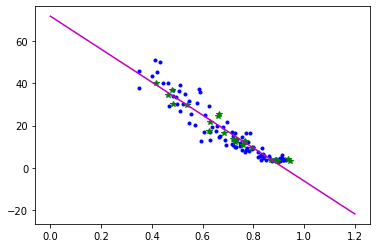

In [432]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [433]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.8795225831559281
The testing R2: 0.9361860408026136


In [434]:
filldata(whole_data,m,b,31)

In [435]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.882306,0.919184,0.882306,0.919184
1,0.883767,0.910677,0.883767,0.910677
2,0.891834,0.855816,0.891834,0.855816
3,0.912203,0.814550,0.912203,0.814550
4,0.879373,0.913286,0.879373,0.913286
Mean,0.889897,0.882703,0.889897,0.882703
Standard Deviation,0.011893,0.041028,0.011893,0.041028


In [436]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.868439,0.944102,0.868439,0.944102
33,0.880086,0.898540,0.880086,0.898540
34,0.920012,0.921526,0.920012,0.921526
35,0.896696,0.917987,0.896696,0.917987
36,0.912440,0.900921,0.912440,0.900921
37,0.912684,0.887543,0.912684,0.887543
38,0.868562,0.830894,0.868562,0.830894
39,0.870808,0.841390,0.870808,0.841390
Mean,0.889421,0.851303,0.889421,0.851303
Standard Deviation,0.002870,0.090755,0.002870,0.090755


## mpi_data
#### We need to find regression models for:
- Population Below National Poverty Line
- Population Below $1.25 per Day

In [437]:
for column in mpi_data.columns:
    df = mpi_data[pd.notna(mpi_data.loc[:,column])]
    df = df.dropna()

In [438]:
mpi_data.columns.get_loc("Population Below $1.25 per Day")

11

### Population Below National Poverty Line

In [439]:
X_test, y_test, X_train, y_train, X, y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below National Poverty Line")

24.716113163621735 59.24226845847036


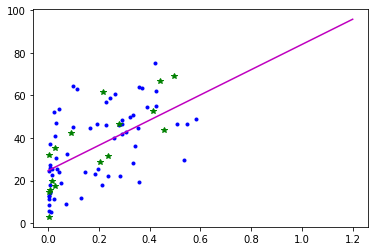

In [440]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [441]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.30591674592739004
The testing R2: 0.5951437324483906


In [442]:
filldatampi(mpi_data, m, b, 11)

In [443]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.325861,0.473678,0.325861,0.473678
1,0.384836,0.308968,0.384836,0.308968
2,0.377676,0.342570,0.377676,0.342570
3,0.420033,0.110662,0.420033,0.110662
4,0.372576,0.380631,0.372576,0.380631
Mean,0.376196,0.323302,0.376196,0.323302
Standard Deviation,0.030150,0.119743,0.030150,0.119743


In [444]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.335202,0.463788,0.335202,0.463788
33,0.384731,0.259692,0.384731,0.259692
34,0.495514,0.685473,0.495514,0.685473
35,0.559250,0.127870,0.559250,0.127870
36,0.533303,0.183394,0.533303,0.183394
37,0.451095,0.011722,0.451095,0.011722
38,0.406349,-0.053343,0.406349,-0.053343
39,0.327763,0.474786,0.327763,0.474786
Mean,0.383929,0.290152,0.383929,0.290152
Standard Deviation,0.052624,0.128645,0.052624,0.128645


### Population Below 1.25 per Day:

In [445]:
X_test, y_test, X_train, y_train, X,y = createTestTrain(df,"Multidimensional Poverty Index (MPI, HDRO)","Population Below $1.25 per Day")

3.370155636161602 127.77751068561237


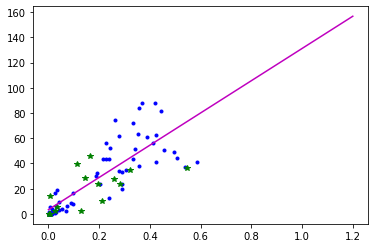

In [446]:
reg = LinearRegression().fit(X_train, y_train)
b, m = reg.intercept_, *reg.coef_
print(b, m)
plotfig()

In [447]:
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 0.6859590018742874
The testing R2: 0.049575720150695446


In [448]:
filldatampi(mpi_data, m, b, 11)

In [449]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,0.687610,0.422076,0.687610,0.422076
1,0.617950,0.839301,0.617950,0.839301
2,0.646216,0.629285,0.646216,0.629285
3,0.644194,0.648464,0.644194,0.648464
4,0.659428,0.598631,0.659428,0.598631
Mean,0.651080,0.627552,0.651080,0.627552
Standard Deviation,0.022684,0.132917,0.022684,0.132917


In [450]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,0.661362,0.745879,0.661362,0.745879
33,0.725738,0.827843,0.725738,0.827843
34,0.662277,0.500738,0.662277,0.500738
35,0.692021,0.589311,0.692021,0.589311
36,0.612868,0.708201,0.612868,0.708201
37,0.710599,0.680033,0.710599,0.680033
38,0.783122,-0.016157,0.783122,-0.016157
39,0.520300,0.620573,0.520300,0.620573
Mean,0.657460,0.718399,0.657460,0.718399
Standard Deviation,0.019582,0.088437,0.019582,0.088437


In [453]:
whole_data = whole_data.dropna()

In [454]:
mpi_data =mpi_data.dropna()

In [455]:
wd_set =set(whole_data.iloc[:,1].to_list())
mpi_set=set(mpi_data.iloc[:,0].to_list())

In [456]:
new_countries =mpi_set.intersection(wd_set.intersection(mpi_set))

In [457]:
keep = list(new_countries)
new_whole_data = whole_data
for i in whole_data.index:
    if not whole_data.loc[i,"Country"] in keep:
        new_whole_data = new_whole_data.drop(i, axis=0)

In [458]:
new_mpi_data = mpi_data
for i in mpi_data.index:
    if not mpi_data.loc[i,"Country"] in keep:
        new_mpi_data = new_mpi_data.drop(i, axis=0)

In [459]:
new_whole_data = new_whole_data.sort_values('Country').reset_index()
new_whole_data.head()

,index,GDI Rank,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),...,Inequality-Adjusted Education Index,Inequality in Income,Inequality-Adjusted Income Index,Human Development Index (1990),Human Development Index (2000),Human Development Index (2010),Human Development Index (2011),Human Development Index (2012),Human Development Index (2013),Human Development Index (2014)
0,170,171.0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,11.3,...,0.202,10.8,0.396,0.297,0.334,0.448,0.456,0.463,0.464,0.465
1,84,85.0,Albania,0.948,0.711,0.75,80.4,75.4,11.9,11.8,...,0.561,18.3,0.567,0.624,0.656,0.722,0.728,0.729,0.732,0.733
2,85,85.0,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,11.2,...,0.679,13.9,0.572,0.632,0.648,0.721,0.723,0.728,0.731,0.733
3,141,142.0,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,9.7,...,0.274,28.3,0.375,0.386,0.468,0.546,0.559,0.563,0.567,0.570
4,165,166.0,Benin,0.823,0.431,0.524,61,58.1,9.4,12.7,...,0.23,29.4,0.306,0.344,0.392,0.468,0.473,0.475,0.477,0.480


In [460]:
new_mpi_data = new_mpi_data.sort_values('Country').reset_index()
new_mpi_data.head()

,index,Country,"Multidimensional Poverty Index (MPI, HDRO)",MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,0,Afghanistan,0.293,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3508.16
1,1,Albania,0.005,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,3,Armenia,0.002,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,5,Bangladesh,0.237,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,9,Benin,0.343,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6


In [461]:
complete_data = pd.concat([new_whole_data, new_mpi_data], axis = 1)

In [462]:
complete_data = complete_data.drop(complete_data.columns[0:2],axis=1)

In [463]:
complete_data = complete_data.loc[:,~complete_data.columns.duplicated()]

In [464]:
complete_data

,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),Mean Years of Education (Female),Mean Years of Education (Male),...,MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
0,Afghanistan,0.6,0.328,0.546,61.6,59.2,7.2,11.3,1.2,5.1,...,58.8,0.353,66.2,17116,49.9,45.6,19.2,35.2,35.8,3508.16
1,Albania,0.948,0.711,0.75,80.4,75.4,11.9,11.8,8.9,9.6,...,1.2,0.005,1.4,38,38.3,22.4,47.1,30.5,14.3,0.5
2,Armenia,1.008,0.734,0.728,78.6,70.9,13.6,11.2,10.8,10.9,...,0.6,0.001,0.3,18,37.0,3.4,87.8,8.7,32,1.8
3,Bangladesh,0.917,0.541,0.59,72.9,70.4,10.3,9.7,4.5,5.5,...,49.5,0.253,51.3,75610,47.8,28.4,26.6,44.9,31.5,43.3
4,Benin,0.823,0.431,0.524,61,58.1,9.4,12.7,2.1,4.6,...,64.2,0.307,62.2,6455,53.3,33.1,24.8,42.1,36.2,51.6
5,Bolivia (Plurinational State of),0.931,0.637,0.684,70.9,65.9,12.9,13.4,7.5,8.9,...,20.6,0.089,20.5,2022,47.0,21.9,27.9,50.2,45,8
6,Burundi,0.911,0.381,0.418,58.7,54.8,9.6,10.7,2.2,3.1,...,81.8,0.454,80.8,7553,54.0,25.0,26.3,48.8,66.9,81.3
7,Cambodia,0.89,0.519,0.584,70.3,66.2,10.3,11.5,3.2,5.4,...,46.8,0.212,45.9,6721,45.1,25.9,27.7,46.4,17.7,10.1
8,Cameroon,0.879,0.478,0.544,56.7,54.4,9.5,11.2,5.3,6.7,...,48.2,0.248,46.0,10187,54.1,24.5,31.3,44.2,39.9,27.6
9,Central African Republic,0.773,0.303,0.392,52.6,48.8,5.9,8.6,2.8,5.7,...,76.3,0.430,77.6,3320,55.6,23.8,26.2,50.0,62,62.8


In [465]:
#Drop Country to compare based on other features 
drp_cntry_complete_data = complete_data
drp_cntry_complete_data.drop(["Country"], axis =1)
correlations =drp_cntry_complete_data.corr()
# plot correlation matrix
fig = plt.figure(figsize=(300, 300))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(list(drp_cntry_complete_data), fontsize=40)
ax.set_yticklabels(list(drp_cntry_complete_data),fontsize=35)
plt.show()
plt.savefig("fig1.png")

<Figure size 432x288 with 0 Axes>

## Simple Regression Models  

In [466]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=.5)
reg.fit(X,y)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [467]:
complete_data.tail()

,Country,Gender Development Index (GDI),Human Development Index (Female),Human Development Index (Male),Life Expectancy at Birth (Female),Life Expectancy at Birth (Male),Expected Years of Education (Female),Expected Years of Education (Male),Mean Years of Education (Female),Mean Years of Education (Male),...,MPI HDRO Percent,"Multidimensional Poverty Index (MPI, 2010)",MPI 2010 Percent,Population in Multidimensional Poverty,Intensity of Deprivation,Education Deprivation,Health Deprivation,Living Standards,Population Below National Poverty Line,Population Below $1.25 per Day
52,Togo,0.831,0.439,0.527,60.4,58.9,10.9,13.4,3,6.3,...,48.5,0.252,50.1,3394,49.9,26.4,28.8,44.9,58.7,52.5
53,Tunisia,0.894,0.671,0.751,77.3,72.5,15,14,5.9,7.8,...,1.5,0.004,1.2,161,39.3,33.7,48.2,18.1,15.5,0.7
54,Uganda,0.886,0.452,0.51,60.3,56.7,9.7,9.9,4.5,6.3,...,70.3,0.367,69.9,24712,51.1,18.0,30.2,51.9,19.5,37.8
55,Ukraine,1.003,0.747,0.745,75.9,66,15.4,14.9,11.3,11.4,...,0.4,0.004,1.2,162,34.5,19.0,77.5,3.5,8.4,0
56,Zambia,0.917,0.558,0.609,62,58.2,13,13.9,5.8,7.3,...,54.4,0.281,56.6,8173,48.6,17.9,29.8,52.3,60.5,74.3


In [468]:
X = np.array(complete_data.iloc[:,3:])
y = np.array(complete_data.iloc[:,2])
n = X.shape[0]
test = int(0.20*n)           
perm = rn.permutation(n)
X = X[perm]
y = y[perm]
X_test = X[:test]      
y_test = y[:test]
X_train = X[test:]     
y_train = y[test:]

In [469]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print('The training R2: {}'.format(reg.score(X_train, y_train)))
print('The testing R2: {}'.format(reg.score(X_test, y_test)))

The training R2: 1.0
The testing R2: 0.9434014320549609


In [470]:
crossVal(X,y)

,train_1,test_1,train_2,test_2
0,1.0,0.992701,0.964606,0.990281
1,1.0,-63.059553,0.974494,0.958524
2,1.0,0.845916,0.971484,0.972776
3,1.0,0.896034,0.974038,0.936426
4,1.0,0.973183,0.978981,0.915885
Mean,1.0,-11.870344,0.972721,0.954778
Standard Deviation,0.0,25.594659,0.004721,0.026260


In [471]:
boots(X,y)

,train_1,test_1,train_2,test_2
32,1.0,0.980577,0.979122,0.979949
33,1.0,0.983535,0.974285,0.985744
34,1.0,0.960792,0.977952,0.911988
35,1.0,0.890494,0.980628,0.704924
36,1.0,0.970437,0.962458,0.980180
37,1.0,0.987805,0.981680,0.988319
38,1.0,-121.516926,0.968950,0.940386
39,1.0,0.972019,0.976840,0.974551
Mean,1.0,0.639651,0.978739,0.968056
Standard Deviation,0.0,0.683616,0.002704,0.005509


## Algorithms for Machine Learning 
#### MLP Regressor

In [653]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes =(10, 10), solver = 'adam', activation = 'identity', alpha=0.0001)
mlp.fit(X_train, y_train)
print('The training R2: {}'.format(mlp.score(X_train, y_train)))
print('The testing R2: {}'.format(mlp.score(X_test, y_test)))

The training R2: -209385295.4405922
The testing R2: -3134705.36122934


#### Sequential Bidirectional LSTM Model

In [667]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from pandas import DataFrame
from pandas import concat
from keras.layers import LSTM
from keras.layers import Bidirectional
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

In [668]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [669]:
values = complete_data.drop(["Country","Gender Development Index (GDI)"], axis = 1).values
values_y = complete_data["Gender Development Index (GDI)"].values

In [670]:
values = values.astype('float32')
values_y = values_y.astype('float32')

In [671]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# # frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

In [672]:
#Splitting data into train test
values_y = values_y[1:]
# split into train and test sets
values = reframed.values
#n_train_hours = 365 * 24
length  = round((len(values)*.75)) #.75 is the cutoff point of the training set
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]
train_X = values[:length, :]
test_X = values[length:, :]
# split into input and outputs
# train_X, train_y = train[:, :-1], train[:, -1]
# test_X, test_y = test[:, :-1], test[:, -1]
train_y = values_y[:length]
test_y = values_y[length:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(42, 1, 106) (42,) (14, 1, 106) (14,)


In [673]:
model = Sequential()
model.add(LSTM(50, activation='softmax', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(optimizer='RMSprop', loss='mae')

In [674]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 50)                31400     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 31,451
Trainable params: 31,451
Non-trainable params: 0
_________________________________________________________________


In [675]:
history = model.fit(train_X, train_y, epochs=30, batch_size=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 42 samples, validate on 14 samples
Epoch 1/30
 - 2s - loss: 0.8708 - val_loss: 0.8584
Epoch 2/30
 - 0s - loss: 0.8474 - val_loss: 0.8415
Epoch 3/30
 - 0s - loss: 0.8311 - val_loss: 0.8271
Epoch 4/30
 - 0s - loss: 0.8169 - val_loss: 0.8138
Epoch 5/30
 - 0s - loss: 0.8038 - val_loss: 0.8012
Epoch 6/30
 - 0s - loss: 0.7912 - val_loss: 0.7890
Epoch 7/30
 - 0s - loss: 0.7789 - val_loss: 0.7769
Epoch 8/30
 - 0s - loss: 0.7669 - val_loss: 0.7651
Epoch 9/30
 - 0s - loss: 0.7550 - val_loss: 0.7534
Epoch 10/30
 - 0s - loss: 0.7434 - val_loss: 0.7421
Epoch 11/30
 - 0s - loss: 0.7321 - val_loss: 0.7312
Epoch 12/30
 - 0s - loss: 0.7214 - val_loss: 0.7211
Epoch 13/30
 - 0s - loss: 0.7115 - val_loss: 0.7116
Epoch 14/30
 - 0s - loss: 0.7023 - val_loss: 0.7031
Epoch 15/30
 - 0s - loss: 0.6940 - val_loss: 0.6953
Epoch 16/30
 - 0s - loss: 0.6865 - val_loss: 0.6882
Epoch 17/30
 - 0s - loss: 0.6796 - val_loss: 0.6816
Epoch 18/30
 - 0s - loss: 0.6732 - val_loss: 0.6755
Epoch 19/30
 - 0s - loss: 0.6

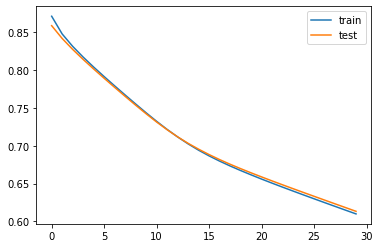

In [676]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [677]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [678]:
inv_yhat = concatenate((yhat, test_X[:, len(complete_data.columns)-1:]), axis=1) #len(dataset.columns) instead of a hard value is 
# used so the value can be dynamically set every time the number of columns changes
# inv_yhat = concatenate((yhat, test_X[:, 8:]), axis=1) # this was the original code for code above
inv_yhat = scaler.inverse_transform(inv_yhat) #inverse_transform UN-scales what we transformed earlier above
inv_yhat = inv_yhat[:,0]

In [679]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, len(complete_data.drop(['Country'], axis =1).columns):]), axis=1) #got tired of putting column #s manually
# inv_y = concatenate((test_y, test_X[:, 8:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# # calculate RMSE
# With forecasts and actual values in their original scale, we can then calculate an error score for the model. 
# In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.308
